In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from google.colab import drive
from array import array
import pandas as pd
import os
import seaborn as sns
drive.mount('/content/gdrive') # 此處需要登入google帳號
data = pd.read_csv("/content/gdrive/My Drive/thesis/thesisdataset/millan_average7_396.csv")
data.shape

Mounted at /content/gdrive


(1679994, 3)

In [ ]:
data2 = pd.read_csv("/content/gdrive/My Drive/thesis/thesisdataset/germany_average3_41.csv")
data2.shape

(1296000, 7)

In [ ]:
data3 = pd.read_csv("/content/gdrive/My Drive/thesis/thesisdataset/uk_data_average5_69_v1.csv")
data3.shape

(19888, 2)

In [ ]:
!nvidia-smi

Thu Apr 21 12:24:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
df = pd.DataFrame(data)
dataset = df.internet.values.astype(float)

In [ ]:
df2 = pd.DataFrame(data2)
dataset2 = df2.load.values.astype(float)

In [ ]:
df3 = pd.DataFrame(data3)
dataset3 = df3.internet.values.astype(float)

In [ ]:
dataset1000=np.append(dataset2, dataset3)
dataset1000=np.append(dataset1000, dataset)

In [ ]:
dataset1000.shape

(2995882,)

In [ ]:
dataset1000

array([0.83439402, 2.67234596, 8.84731518, ..., 3.04733812, 2.58051192,
       2.45250131])

In [ ]:
dataset1000.shape

(2995882,)

In [ ]:
dataset1000=dataset1000.reshape(-1,1)

In [ ]:
dataset1000.shape

(2995882, 1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
dataset1000 = sc.fit_transform(dataset1000)

seq_length = 1
x, y = sliding_windows(dataset1000, seq_length)
train_size = 2097200
#test_size = 898761
#train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
print(trainX.shape)

torch.Size([2097200, 1, 1])


In [ ]:
print(trainY.shape)

torch.Size([2097200, 1])


In [ ]:
print(testX.shape)

torch.Size([898681, 1, 1])


In [ ]:
print(testY.shape)

torch.Size([898681, 1])


In [ ]:
print(testX.shape)
print(testY.shape)

torch.Size([898681, 1, 1])
torch.Size([898681, 1])


In [ ]:
trainX=trainX.reshape(2097200,1,24)
trainY=trainY.reshape(2097200,1)
testX=testX.reshape(898658,1,24)
testY=testY.reshape(898658,1)

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_dim = 1
hidden_dim = 2
layer_dim = 1  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 1
dropout = 0.2

gru = GRUModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = gru(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, loss: 0.00315
Epoch: 100, loss: 0.00008
Epoch: 200, loss: 0.00007
Epoch: 300, loss: 0.00007
Epoch: 400, loss: 0.00007
Epoch: 500, loss: 0.00007
Epoch: 600, loss: 0.00007
Epoch: 700, loss: 0.00007
Epoch: 800, loss: 0.00007
Epoch: 900, loss: 0.00007
Epoch: 1000, loss: 0.00007
Epoch: 1100, loss: 0.00007
Epoch: 1200, loss: 0.00007
Epoch: 1300, loss: 0.00007
Epoch: 1400, loss: 0.00007
Epoch: 1500, loss: 0.00007
Epoch: 1600, loss: 0.00006
Epoch: 1700, loss: 0.00006
Epoch: 1800, loss: 0.00006
Epoch: 1900, loss: 0.00006


In [ ]:
dataX.shape

torch.Size([2995881, 1, 1])

In [ ]:
from math import sqrt

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error


print("mean_absolute_error:",mean_absolute_error(dataY_plot, data_predict))

print("mean_squared_error:",mean_squared_error(dataY_plot, data_predict))

print("rmse:",sqrt(mean_squared_error(dataY_plot, data_predict)))

print("r2 score:",r2_score(dataY_plot, data_predict))
print("mape_sk", mean_absolute_percentage_error(dataY_plot, data_predict))

mean_absolute_error: 3.3534112
mean_squared_error: 27.304382
rmse: 5.225359540186565
r2 score: 0.7733704386164743
mape_sk 216911000000.0


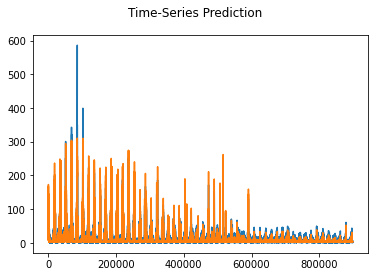

In [ ]:
#V seq=1 168000
gru.eval()
test_predict = gru(testX)

test_predict = test_predict.data.numpy()
testY_plot = testY.data.numpy()

test_predict = sc.inverse_transform(test_predict)
testY_plot = sc.inverse_transform(testY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(testY_plot)
plt.plot(test_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
from math import sqrt

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error


print("mean_absolute_error:",mean_absolute_error(testY_plot, test_predict))

print("mean_squared_error:",mean_squared_error(testY_plot, test_predict))

print("rmse:",sqrt(mean_squared_error(testY_plot, test_predict)))

print("r2 score:",r2_score(testY_plot, test_predict))
print("mape_sk", mean_absolute_percentage_error(testY_plot, test_predict))

mean_absolute_error: 3.592984
mean_squared_error: 40.519474
rmse: 6.365490871059436
r2 score: 0.8577262761199329
mape_sk 723103700000.0


In [ ]:
np.seterr(divide='ignore', invalid='ignore')
print("mape", mape(testY_plot, test_predict))

mape inf


In [ ]:
import joblib
joblib.dump(gru,"/content/gdrive/My Drive/thesis/gru0419_length=1_batch_1.pkl")

['/content/gdrive/My Drive/thesis/gru0419_length=1_batch_1.pkl']